# 05 - Active City Index

**Ziel:** Fuehrt alle Teilindikatoren zusammen und berechnet den Active City Index.

**Inputs:** interim + processed Indikator-Dateien aus 01-04

**Outputs:** data/processed/muc_active_city_index.(csv|geojson|gpkg)

**Ausfuehrung:** Von oben nach unten ausfuehren (Restart & Run All). Dieses Notebook ist Teil der Pipeline 00 -> 05.


## Setup
Hier werden Bibliotheken, Darstellungsoptionen und Dateipfade vorbereitet. Damit sind alle nachfolgenden Berechnungen reproduzierbar und auf eine konsistente Ordnerstruktur abgestimmt.


In [180]:
import geopandas as gpd
from pathlib import Path
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

# Zentrale Projektpfade (einheitliche IO-Basis für das gesamte Notebook)
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
INTERIM_DIR = DATA_DIR / "interim"
PROCESSED_DIR = DATA_DIR / "processed"
# Standardisierte Output-Ordner fuer Notebook 05
OUTPUT_DIR = BASE_DIR / "outputs"
FIG_DIR = OUTPUT_DIR / "figures" / "05_active_index"
TABLE_DIR = OUTPUT_DIR / "tables" / "05_active_index"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)
BASE_DIR, INTERIM_DIR, PROCESSED_DIR


(PosixPath('..'), PosixPath('../data/interim'), PosixPath('../data/processed'))

In [181]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np

# Gemeinsame Parameter/Hilfswerte fuer die optionalen Qualitaetsindikatoren
place_name = "München, Deutschland"
public_access_values = {"yes", "public", "permissive", "destination"}


def _safe_series(df, col, default=""):
    # Liefert Spalte robust als String-Serie; bei fehlender Spalte wird ein Default erzeugt.
    if col in df.columns:
        return df[col].astype(str).str.lower().fillna(default)
    return pd.Series([default] * len(df), index=df.index)


def _minmax(series):
    # Min-Max-Normierung mit sicherem Fallback fuer konstante Serien.
    s = pd.to_numeric(series, errors="coerce").fillna(0.0)
    den = s.max() - s.min()
    if den == 0:
        return pd.Series(0.0, index=s.index)
    return (s - s.min()) / den


## Datenbasis und Indexaufbau
Die vorbereiteten Basis- und Themenlayer (Parks, Sport, Mobility) werden eingelesen und kurz geprueft.
Die Teil-Datensaetze werden zu einem gemeinsamen Analyse-GeoDataFrame (`gdf_active`) zusammengefuehrt.


In [182]:
# Basis: Bezirke + Bevölkerung + Fläche
gdf_base = gpd.read_file(INTERIM_DIR / "muc_bezirke_bev_clean.geojson")

# Parks
gdf_parks = gpd.read_file(PROCESSED_DIR / "muc_bezirke_parks.geojson")[
    [
        "bez_nr",
        "parks_count",
        "parks_area_ha",
        "parks_pro_1000_einw",
        "parks_area_anteil_prozent",
    ]
]

# Sport
gdf_sport = gpd.read_file(PROCESSED_DIR / "muc_bezirke_sport.geojson")[
    [
        "bez_nr",
        "sports_count",
        "sports_area_ha",
        "sports_pro_1000_einw",
        "sports_area_anteil_prozent",
    ]
]

# Mobility (ÖPNV + Radwege)
gdf_mob = gpd.read_file(PROCESSED_DIR / "muc_bezirke_mobility.geojson")[
    [
        "bez_nr",
        "stops_count",
        "stops_pro_1000_einw",
        "radweg_length_m",
        "radweg_km",
        "radweg_km_pro_km2",
    ]
]


In [183]:
gdf_base.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   bez_nr           25 non-null     int32   
 1   name             25 non-null     object  
 2   stadtbezirk      25 non-null     object  
 3   einwohner        25 non-null     int32   
 4   flaeche_ha       25 non-null     float64 
 5   einwohnerdichte  25 non-null     float64 
 6   geometry         25 non-null     geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 1.3+ KB


In [184]:
gdf_parks.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bez_nr                     25 non-null     int32  
 1   parks_count                25 non-null     int32  
 2   parks_area_ha              25 non-null     float64
 3   parks_pro_1000_einw        25 non-null     float64
 4   parks_area_anteil_prozent  25 non-null     float64
dtypes: float64(3), int32(2)
memory usage: 932.0 bytes


In [185]:
gdf_sport.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bez_nr                      25 non-null     int32  
 1   sports_count                25 non-null     int32  
 2   sports_area_ha              25 non-null     float64
 3   sports_pro_1000_einw        25 non-null     float64
 4   sports_area_anteil_prozent  25 non-null     float64
dtypes: float64(3), int32(2)
memory usage: 932.0 bytes


In [186]:
gdf_mob.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bez_nr               25 non-null     int32  
 1   stops_count          25 non-null     int32  
 2   stops_pro_1000_einw  25 non-null     float64
 3   radweg_length_m      25 non-null     float64
 4   radweg_km            25 non-null     float64
 5   radweg_km_pro_km2    25 non-null     float64
dtypes: float64(4), int32(2)
memory usage: 1.1 KB


### Zusammenfuehrung zum Analyse-Datensatz `gdf_active`
Die Teil-Datensaetze aus Gruen, Sport und Mobilitaet werden auf Bezirksebene zusammengefuehrt. Fehlende Werte in Kennzahlspalten werden bewusst als `0` behandelt, um einen vollstaendigen Vergleich ueber alle 25 Bezirke zu ermoeglichen.


In [187]:
# Ergebnis: gdf_active = 25 Bezirke mit allen Indikatoren für Grün, Sport und Mobilität
# Alle Themenlayer über den Bezirksschlüssel zusammenführen.
gdf_active = (
    gdf_base.merge(gdf_parks, on="bez_nr", how="left")
    .merge(gdf_sport, on="bez_nr", how="left")
    .merge(gdf_mob, on="bez_nr", how="left")
)
# Kennzahlspalten, die nach dem Merge lückenlos vorliegen sollen.
kennzahl_spalten = [
    "parks_count",
    "parks_area_ha",
    "parks_pro_1000_einw",
    "parks_area_anteil_prozent",
    "sports_count",
    "sports_area_ha",
    "sports_pro_1000_einw",
    "sports_area_anteil_prozent",
    "stops_count",
    "stops_pro_1000_einw",
    "radweg_length_m",
    "radweg_km",
    "radweg_km_pro_km2",
]
# Fehlende Werte als 0 behandeln, um vollständige Bezirkvergleiche zu ermöglichen.
for col in kennzahl_spalten:
    gdf_active[col] = gdf_active[col].fillna(0)
# Schnellansicht zentraler Indikatoren für die Plausibilitätsprüfung.
gdf_active[
    [
        "bez_nr",
        "name",
        "einwohner",
        "parks_pro_1000_einw",
        "sports_pro_1000_einw",
        "stops_pro_1000_einw",
        "radweg_km_pro_km2",
    ]
].head()


,bez_nr,name,einwohner,parks_pro_1000_einw,sports_pro_1000_einw,stops_pro_1000_einw,radweg_km_pro_km2
0,1,Altstadt-Lehel,20876,1.293351,0.910136,8.478636,7.950604
1,2,Ludwigsvorstadt-Isarvorstadt,50081,0.419321,0.738803,6.629261,7.694313
2,3,Maxvorstadt,52434,0.648434,0.858222,3.642675,6.513534
3,4,Schwabing-West,68610,0.335228,0.816208,2.565224,8.608748
4,5,Au-Haidhausen,63972,0.562746,1.031701,3.923592,7.219785


In [188]:
assert len(gdf_active) == 25
assert gdf_active.isna().sum().sum() == 0


#### Erkenntnisse (Datenzusammenfuehrung)
- Der integrierte Datensatz umfasst **25 Bezirke** mit vollstaendigen Kernindikatoren ueber alle drei Domaenen.
- Die Null-Imputation fuer fehlende Kennzahlwerte verhindert Luecken in spaeteren Rankings und Karten.
- Methodisch wichtig: Im Bericht sollte klar erwaehnt werden, dass `0` hier als "kein nachweisbares Angebot im Datensatz" interpretiert wird.


### Konfiguration der Index-Dimensionen und Indikatoren
Hier wird festgelegt, welche Indikatoren in die drei Domaenen einfliessen. Diese Zuordnung ist die zentrale methodische Grundlage fuer die spaetere Indexbildung.


In [189]:
# Grün & Erholung
GREEN_INDICATORS = [
    "parks_pro_1000_einw",
    "parks_area_anteil_prozent",
]

# Sportinfrastruktur
SPORT_INDICATORS = [
    "sports_pro_1000_einw",
    "sports_area_anteil_prozent",
]

# Mobilität (ÖPNV + Radwege)
MOBILITY_INDICATORS = [
    "stops_pro_1000_einw",
    "radweg_km_pro_km2",
]

# Alle verwendeten Indikatoren in einer Liste sammeln (für Normalisierung)
ALL_INDICATORS = list(set(GREEN_INDICATORS + SPORT_INDICATORS + MOBILITY_INDICATORS))

ALL_INDICATORS


['sports_pro_1000_einw',
 'parks_area_anteil_prozent',
 'radweg_km_pro_km2',
 'parks_pro_1000_einw',
 'sports_area_anteil_prozent',
 'stops_pro_1000_einw']

### Index-Engine (Normalisierung und Gewichtung)
Die Engine skaliert alle Indikatoren auf einen gemeinsamen Wertebereich und aggregiert sie zuerst zu Domaenen, dann zum Gesamtindex. So werden unterschiedliche Einheiten vergleichbar gemacht.


In [190]:
# Normalisierungsfunktion
def normalize_series(x, method="minmax"):
    if method == "minmax":
        return (x - x.min()) / (x.max() - x.min())
    elif method == "zscore":
        return (x - x.mean()) / x.std()
    else:
        raise ValueError("Unknown method")


In [191]:
# Funktion zur Berechnung des Active City Index
def compute_active_city_index(
    gdf, green_ind, sport_ind, mob_ind, weights=None, norm_method="minmax"
):
    if weights is None:
        weights = {"green": 1 / 3, "sport": 1 / 3, "mob": 1 / 3}

    all_inds = list(set(green_ind + sport_ind + mob_ind))

    # 1) Normalisierung
    for col in all_inds:
        col_norm = col + "_norm"
        gdf[col_norm] = normalize_series(gdf[col], method=norm_method)

    # 2) Teilindizes
    gdf["index_gruen"] = gdf[[c + "_norm" for c in green_ind]].mean(axis=1)
    gdf["index_sport"] = gdf[[c + "_norm" for c in sport_ind]].mean(axis=1)
    gdf["index_mobil"] = gdf[[c + "_norm" for c in mob_ind]].mean(axis=1)

    # 3) Gesamtindex
    gdf["active_city_index"] = (
        weights["green"] * gdf["index_gruen"]
        + weights["sport"] * gdf["index_sport"]
        + weights["mob"] * gdf["index_mobil"]
    )
    return gdf


### Baseline-Index mit gleichen Gewichten
Im Baseline-Szenario werden Gruen, Sport und Mobilitaet gleich stark gewichtet. Dieses Szenario dient als neutraler Referenzpunkt fuer die spaeteren Robustheitsvergleiche.


In [192]:
active_index = compute_active_city_index(
    gdf_active,
    GREEN_INDICATORS,
    SPORT_INDICATORS,
    MOBILITY_INDICATORS,
    weights={"green": 1 / 3, "sport": 1 / 3, "mob": 1 / 3},
)


In [193]:
# Kernspalten für Ranking und Berichtsausgabe bündeln.
cols = [
    "bez_nr",
    "name",
    "active_city_index",
    "index_gruen",
    "index_sport",
    "index_mobil",
]
# Gesamtindex absteigend ausgeben (Top-Bezirke zuerst).
baseline_table = (
    active_index[cols]
    .sort_values("active_city_index", ascending=False)
    .reset_index(drop=True)
)
baseline_table.to_csv(
    TABLE_DIR / "01_baseline_ranking.csv", index=False, float_format="%.4f"
)
baseline_table.head(25)


,bez_nr,name,active_city_index,index_gruen,index_sport,index_mobil
0,1,Altstadt-Lehel,0.650981,0.991307,0.147427,0.814208
1,11,Milbertshofen-Am Hart,0.591846,0.309604,0.937321,0.528612
2,15,Trudering-Riem,0.572067,0.519702,0.767300,0.429199
3,6,Sendling,0.560835,0.521128,0.645821,0.515555
4,12,Schwabing-Freimann,0.529419,0.436089,0.751703,0.400466
5,7,Sendling-Westpark,0.510870,0.429676,0.641804,0.461129
6,18,Untergiesing-Harlaching,0.481696,0.390645,0.630459,0.423984
7,10,Moosach,0.454242,0.334937,0.564410,0.463379
8,16,Ramersdorf-Perlach,0.445368,0.193787,0.642858,0.499459
9,9,Neuhausen-Nymphenburg,0.423575,0.709149,0.346154,0.215423


#### Erkenntnisse (Baseline-Ranking)
- Die Baseline zeigt eine klare Spannweite: `active_city_index` von **0.188** bis **0.651** (Median **0.353**).
- Top-Bezirke sind **Altstadt-Lehel (0.651)**, **Milbertshofen-Am Hart (0.592)** und **Trudering-Riem (0.572)**.
- Am unteren Ende liegen **Laim (0.188)**, **Feldmoching-Hasenbergl (0.219)** und **Maxvorstadt (0.220)**.


In [194]:
assert active_index["active_city_index"].between(0, 1).all()
assert active_index["index_gruen"].between(0, 1).all()
assert len(active_index) == 25  # 25 Stadtbezirke


## Analyse des Baseline-Index
Die folgenden Auswertungen zeigen Niveau, Streuung und raeumliche Verteilung des Baseline-Index. Ziel ist, belastbare Muster fuer den Projektbericht sichtbar zu machen.


### Verteilung und Ranking des Active City Index
Zur Einordnung des Index betrachten wir:
- die Verteilung der Indexwerte ueber alle Stadtbezirke (Histogramm)
- ein Ranking der Bezirke (Top/Bottom-Bezirke)


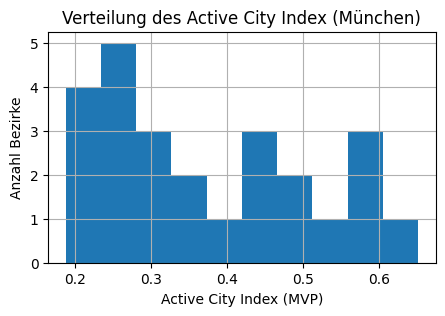

In [195]:
plt.figure(figsize=(5, 3))
active_index["active_city_index"].hist(bins=10)
plt.xlabel("Active City Index (MVP)")
plt.ylabel("Anzahl Bezirke")
plt.title("Verteilung des Active City Index (München)")
plt.savefig(
    FIG_DIR / "01_distribution_active_city_index.png", dpi=180, bbox_inches="tight"
)
plt.show()


In [196]:
ranking = (
    active_index[cols]
    .sort_values("active_city_index", ascending=False)
    .reset_index(drop=True)
)


In [197]:
top5 = ranking.head(5)
bottom5 = ranking.tail(5)

display(top5)
display(bottom5)


,bez_nr,name,active_city_index,index_gruen,index_sport,index_mobil
0,1,Altstadt-Lehel,0.650981,0.991307,0.147427,0.814208
1,11,Milbertshofen-Am Hart,0.591846,0.309604,0.937321,0.528612
2,15,Trudering-Riem,0.572067,0.519702,0.767300,0.429199
3,6,Sendling,0.560835,0.521128,0.645821,0.515555
4,12,Schwabing-Freimann,0.529419,0.436089,0.751703,0.400466


,bez_nr,name,active_city_index,index_gruen,index_sport,index_mobil
20,4,Schwabing-West,0.238221,0.185068,0.151581,0.378015
21,20,Hadern,0.220725,0.135574,0.267076,0.259525
22,3,Maxvorstadt,0.219909,0.263824,0.061207,0.334695
23,24,Feldmoching-Hasenbergl,0.219346,0.047015,0.486667,0.124356
24,25,Laim,0.188044,0.199666,0.080665,0.283801


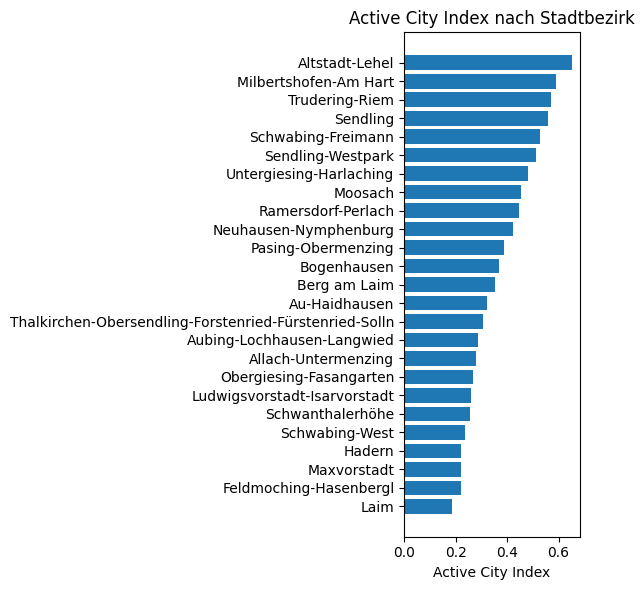

In [198]:
ordered = active_index[["name", "active_city_index"]].sort_values(
    "active_city_index", ascending=True
)
ordered.to_csv(
    TABLE_DIR / "02_ranking_active_city_index_ordered.csv",
    index=False,
    float_format="%.4f",
)
plt.figure(figsize=(6, 6))
plt.barh(ordered["name"], ordered["active_city_index"])
plt.xlabel("Active City Index")
plt.title("Active City Index nach Stadtbezirk")
plt.tight_layout()
plt.savefig(
    FIG_DIR / "02_ranking_active_city_index_barh.png", dpi=180, bbox_inches="tight"
)
plt.show()


#### Erkenntnisse (Verteilung und Ranking)
- Histogramm und Balkenplot zeigen keine gleichmaessige Verteilung, sondern einen klaren Leistungsabstand zwischen Spitzengruppe und unteren Rängen.
- Die Visualisierung erleichtert die Identifikation von Bezirken mit strukturellem Aufholbedarf.
- Fuer den Bericht: Rankings immer zusammen mit Domaenenwerten interpretieren, um Scheinklarheit durch einen Einzelwert zu vermeiden.


### Raeumliche Verteilung des Active City Index
Der Index wird als Choroplethenkarte auf Bezirksebene visualisiert, um raeumliche Muster zu erkennen.


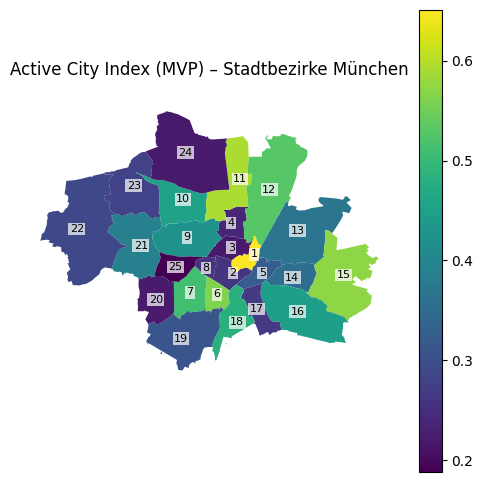

In [199]:
# Baseline-Index als Choropleth darstellen.
ax = active_index.plot(column="active_city_index", legend=True, figsize=(6, 6))
# Bezirksnummern robust labeln (sb_nummer bevorzugt, sonst bez_nr).
label_col = "sb_nummer" if "sb_nummer" in active_index.columns else "bez_nr"
for _, row in active_index.iterrows():
    rp = row.geometry.representative_point()
    ax.text(
        rp.x,
        rp.y,
        str(row[label_col]),
        fontsize=8,
        ha="center",
        va="center",
        color="black",
        bbox={"facecolor": "white", "alpha": 0.7, "edgecolor": "none", "pad": 1},
    )
plt.title("Active City Index (MVP) – Stadtbezirke München")
plt.axis("off")
plt.savefig(
    FIG_DIR / "03_choropleth_active_city_index.png", dpi=180, bbox_inches="tight"
)
plt.show()


#### Erkenntnisse (Raeumliche Verteilung)
- Die Karte macht raeumliche Cluster sichtbar und ergaenzt die tabellarischen Rankings um einen Lagebezug.
- Bezirke mit niedrigen Werten in benachbarten Lagen deuten auf zusammenhaengende Versorgungsdefizite hin.
- Das unterstuetzt priorisierte Massnahmenpakete auf Teilraum-Ebene statt isolierter Einzelmassnahmen.


### Zusammenhaenge und Korrelationen
Hier wird geprueft, wie stark die Domaenen mit dem Gesamtindex zusammenhaengen und ob Teilindikatoren aehnliche Muster zeigen. Das hilft bei der methodischen Einordnung der Indexkonstruktion.


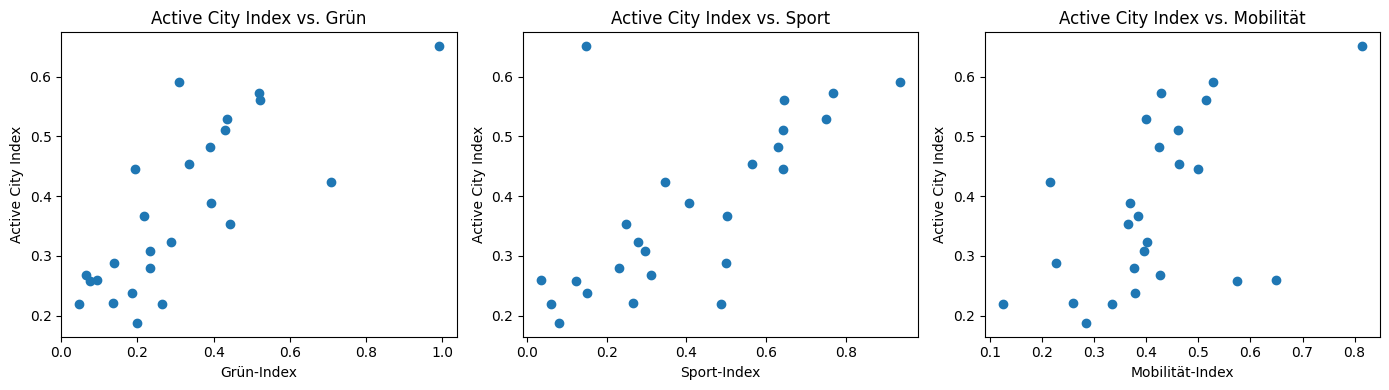

In [200]:
# Streudiagramme: Beitrag jeder Domäne zum Gesamtindex visualisieren.
dims = ["index_gruen", "index_sport", "index_mobil"]
titles = ["Grün", "Sport", "Mobilität"]
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for col, title, ax in zip(dims, titles, axes):
    ax.scatter(active_index[col], active_index["active_city_index"])
    ax.set_xlabel(f"{title}-Index")
    ax.set_ylabel("Active City Index")
    ax.set_title(f"Active City Index vs. {title}")
plt.tight_layout()
plt.savefig(FIG_DIR / "04_scatter_domains_vs_index.png", dpi=180, bbox_inches="tight")
plt.show()


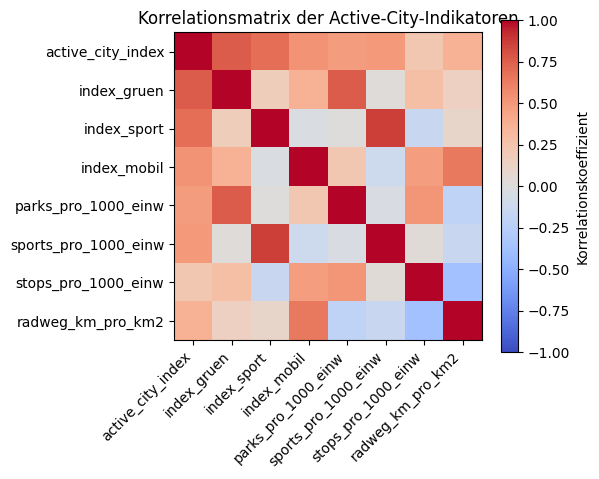

In [201]:
# Korrelationen zwischen Gesamtindex, Domaenen und Kernindikatoren berechnen
corr_cols = [
    "active_city_index",
    "index_gruen",
    "index_sport",
    "index_mobil",
    "parks_pro_1000_einw",
    "sports_pro_1000_einw",
    "stops_pro_1000_einw",
    "radweg_km_pro_km2",
]
corr = active_index[corr_cols].corr()
corr.to_csv(TABLE_DIR / "03_korrelationsmatrix.csv", float_format="%.4f")
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
ax.set_xticks(np.arange(len(corr_cols)))
ax.set_yticks(np.arange(len(corr_cols)))
ax.set_xticklabels(corr_cols, rotation=45, ha="right")
ax.set_yticklabels(corr_cols)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Korrelationskoeffizient")
ax.set_title("Korrelationsmatrix der Active-City-Indikatoren")
plt.tight_layout()
plt.savefig(FIG_DIR / "05_heatmap_korrelationen.png", dpi=180, bbox_inches="tight")
plt.show()


#### Erkenntnisse (Korrelationen)
- Die Korrelationsmatrix macht die erwartete positive Kopplung zwischen Domaenen-Indizes und Gesamtindex sichtbar.
- Aus den Domaenen-Medianen (`Gruen 0.264`, `Sport 0.346`, `Mobilitaet 0.401`) wird deutlich, dass Gruen in der Baseline tendenziell das niedrigste Niveau aufweist.
- Berichtsrelevant: Korrelationen zeigen Zusammenhang, aber keine Kausalitaet.


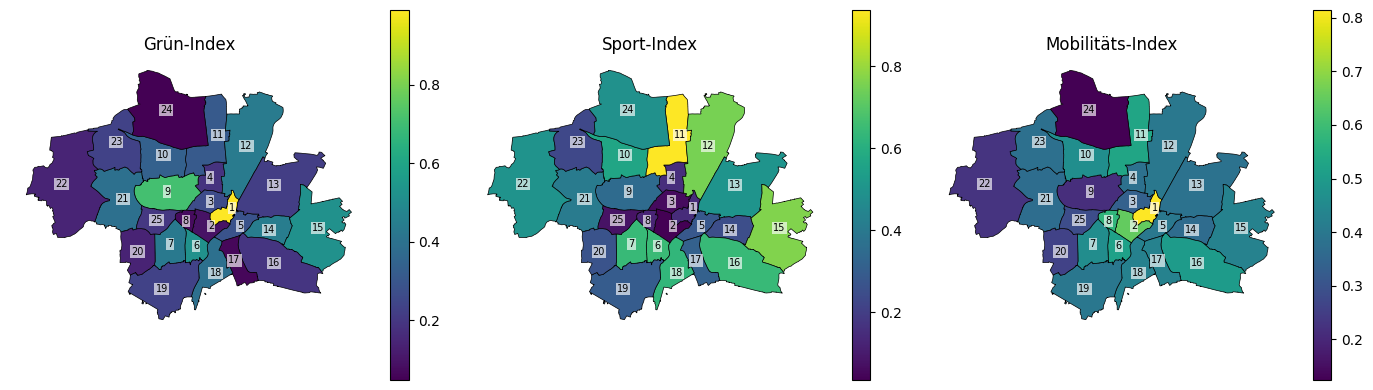

In [202]:
# Domänenkarten nebeneinander plotten, um räumliche Unterschiede direkt zu vergleichen.
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
# Bezirksnummern robust labeln (sb_nummer bevorzugt, sonst bez_nr).
label_col = "sb_nummer" if "sb_nummer" in active_index.columns else "bez_nr"
for col, title, ax in zip(
    ["index_gruen", "index_sport", "index_mobil"],
    ["Grün-Index", "Sport-Index", "Mobilitäts-Index"],
    axes,
):
    active_index.plot(
        column=col, cmap="viridis", legend=True, edgecolor="black", linewidth=0.5, ax=ax
    )
    for _, row in active_index.iterrows():
        rp = row.geometry.representative_point()
        ax.text(
            rp.x,
            rp.y,
            str(row[label_col]),
            fontsize=7,
            ha="center",
            va="center",
            color="black",
            bbox={"facecolor": "white", "alpha": 0.65, "edgecolor": "none", "pad": 0.8},
        )
    ax.set_axis_off()
    ax.set_title(title)
plt.tight_layout()
plt.savefig(FIG_DIR / "06_choropleth_domains.png", dpi=180, bbox_inches="tight")
plt.show()


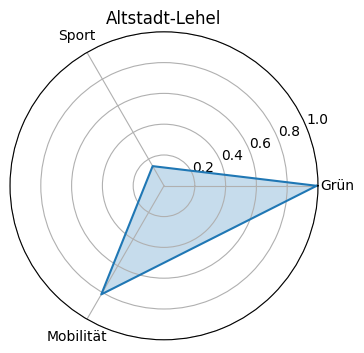

In [203]:
# Spinnenrad-Plot für einen Bezirk
import numpy as np


def plot_bezirk_profile(row):
    labels = ["Grün", "Sport", "Mobilität"]
    values = [row["index_gruen"], row["index_sport"], row["index_mobil"]]
    values += values[:1]  # Radar close
    angles = np.linspace(0, 2 * np.pi, len(labels) + 1)
    fig, ax = plt.subplots(subplot_kw={"polar": True}, figsize=(4, 4))
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1)
    ax.set_title(row["name"])
    plt.savefig(
        FIG_DIR / f"07_radar_{row['bez_nr']:02d}_{row['name'].replace(' ', '_')}.png",
        dpi=180,
        bbox_inches="tight",
    )
    plt.show()


# Beispiel für einen Bezirk:
plot_bezirk_profile(active_index.iloc[0])


## Robustheitsanalyse
In diesem Block wird geprueft, wie stabil Rankings bei geaenderten Gewichten oder beim Entfernen einzelner Indikatoren bleiben. Damit wird die Sensitivitaet des Index transparent gemacht.


In [204]:
# Zusätzliche Gewichtungsszenarien nur anlegen, falls sie noch nicht existieren.
if "aci_equal" not in active_index.columns:
    active_index["aci_equal"] = active_index["active_city_index"]
if "aci_green_focus" not in active_index.columns:
    active_index["aci_green_focus"] = (
        0.5 * active_index["index_gruen"]
        + 0.25 * active_index["index_sport"]
        + 0.25 * active_index["index_mobil"]
    )
if "aci_sport_focus" not in active_index.columns:
    active_index["aci_sport_focus"] = (
        0.25 * active_index["index_gruen"]
        + 0.5 * active_index["index_sport"]
        + 0.25 * active_index["index_mobil"]
    )
if "aci_mob_focus" not in active_index.columns:
    active_index["aci_mob_focus"] = (
        0.25 * active_index["index_gruen"]
        + 0.25 * active_index["index_sport"]
        + 0.5 * active_index["index_mobil"]
    )
# Für jede Variante Rangpositionen bilden.
for score_col in ["aci_equal", "aci_green_focus", "aci_sport_focus", "aci_mob_focus"]:
    active_index[f"rank_{score_col}"] = (
        active_index[score_col].rank(ascending=False, method="min").astype(int)
    )
# Rangdifferenzen zur Baseline vorbereiten.
robustheit_ranking = active_index[
    [
        "bez_nr",
        "name",
        "rank_aci_equal",
        "rank_aci_green_focus",
        "rank_aci_sport_focus",
        "rank_aci_mob_focus",
    ]
].copy()
robustheit_ranking["delta_green_vs_equal"] = (
    robustheit_ranking["rank_aci_green_focus"] - robustheit_ranking["rank_aci_equal"]
)
robustheit_ranking["delta_sport_vs_equal"] = (
    robustheit_ranking["rank_aci_sport_focus"] - robustheit_ranking["rank_aci_equal"]
)
robustheit_ranking["delta_mob_vs_equal"] = (
    robustheit_ranking["rank_aci_mob_focus"] - robustheit_ranking["rank_aci_equal"]
)


In [205]:
# Einheitliche Top-N-Ausgabe fuer die verschiedenen Gewichtungsszenarien
def top_n_for_variant(df, score_col, n=5):
    return (
        df[["bez_nr", "name", score_col]]
        .sort_values(score_col, ascending=False)
        .head(n)
        .reset_index(drop=True)
    )


variant_tables = {
    "aci_equal": top_n_for_variant(active_index, "aci_equal"),
    "aci_green_focus": top_n_for_variant(active_index, "aci_green_focus"),
    "aci_sport_focus": top_n_for_variant(active_index, "aci_sport_focus"),
    "aci_mob_focus": top_n_for_variant(active_index, "aci_mob_focus"),
}
for key, table in variant_tables.items():
    table.to_csv(TABLE_DIR / f"04_top5_{key}.csv", index=False, float_format="%.4f")
print("Top 5 – equal weights:")
display(variant_tables["aci_equal"])
print("Top 5 – Grün-fokus:")
display(variant_tables["aci_green_focus"])
print("Top 5 – Sport-fokus:")
display(variant_tables["aci_sport_focus"])
print("Top 5 – Mobilitäts-fokus:")
display(variant_tables["aci_mob_focus"])


Top 5 – equal weights:


,bez_nr,name,aci_equal
0,1,Altstadt-Lehel,0.650981
1,11,Milbertshofen-Am Hart,0.591846
2,15,Trudering-Riem,0.572067
3,6,Sendling,0.560835
4,12,Schwabing-Freimann,0.529419


Top 5 – Grün-fokus:


,bez_nr,name,aci_green_focus
0,1,Altstadt-Lehel,0.736062
1,15,Trudering-Riem,0.558976
2,6,Sendling,0.550908
3,11,Milbertshofen-Am Hart,0.521285
4,12,Schwabing-Freimann,0.506087


Top 5 – Sport-fokus:


,bez_nr,name,aci_sport_focus
0,11,Milbertshofen-Am Hart,0.678214
1,15,Trudering-Riem,0.620875
2,12,Schwabing-Freimann,0.584990
3,6,Sendling,0.582081
4,7,Sendling-Westpark,0.543604


Top 5 – Mobilitäts-fokus:


,bez_nr,name,aci_mob_focus
0,1,Altstadt-Lehel,0.691787
1,11,Milbertshofen-Am Hart,0.576037
2,6,Sendling,0.549515
3,15,Trudering-Riem,0.536350
4,7,Sendling-Westpark,0.498435


In [206]:
# Spearmans Rangkorrelation zwischen den verschiedenen Index-Varianten

from scipy.stats import spearmanr

index_variants = ["aci_equal", "aci_green_focus", "aci_sport_focus", "aci_mob_focus"]

print("Spearman-Rangkorrelationen der Indexvarianten:\n")

for var in index_variants[1:]:
    rho, p = spearmanr(active_index["aci_equal"], active_index[var])
    print(f"aci_equal vs {var}: ρ = {rho:.3f}, p = {p:.3f}")


Spearman-Rangkorrelationen der Indexvarianten:

aci_equal vs aci_green_focus: ρ = 0.969, p = 0.000
aci_equal vs aci_sport_focus: ρ = 0.952, p = 0.000
aci_equal vs aci_mob_focus: ρ = 0.964, p = 0.000


#### Erkenntnisse (Gewichtungsszenarien)
- Die Spearman-Korrelationen zwischen Baseline und Varianten sind durchgehend hoch (**rho ca. 0.95-0.97**).
- Das spricht fuer ein insgesamt stabiles Ranking trotz alternativer normativer Gewichtungen.
- Einzelne Rangverschiebungen bleiben jedoch politisch relevant und sollten transparent berichtet werden.


### Rangverschiebungen zwischen Gewichtungsszenarien
Die groessten Rangveraenderungen zeigen, welche Bezirke besonders stark von normativen Gewichtungsentscheidungen abhaengen. Das ist wichtig fuer eine faire Interpretation im Bericht.


In [207]:
# Bezirke mit stärkster Rangverschiebung identifizieren
def rank_positions(df, score_col):
    """
    Gibt ein Dict {Bezirkname: Rangposition} zurück,
    Rang 1 = höchster Score.
    """
    ranking = (
        df[["name", score_col]]
        .sort_values(score_col, ascending=False)
        .reset_index(drop=True)
    )
    return {row["name"]: i + 1 for i, row in ranking.iterrows()}


# Rangpositionen für alle Varianten
ranks_equal = rank_positions(active_index, "aci_equal")
ranks_green_focus = rank_positions(active_index, "aci_green_focus")
ranks_sport_focus = rank_positions(active_index, "aci_sport_focus")
ranks_mob_focus = rank_positions(active_index, "aci_mob_focus")


def rank_diff_list(base_ranks, alt_ranks, label):
    diffs = []
    for name in base_ranks:
        diff = alt_ranks[name] - base_ranks[name]  # positiv = schlechterer Rang
        diffs.append((name, base_ranks[name], alt_ranks[name], diff))
    diffs_sorted = sorted(diffs, key=lambda x: abs(x[3]), reverse=True)
    print(f"\nTop 5 Rangverschiebungen für {label}:")
    for name, base_pos, alt_pos, diff in diffs_sorted[:5]:
        print(f"- {name}: von Rang {base_pos} auf Rang {alt_pos} (Δ = {diff})")


rank_diff_list(ranks_equal, ranks_green_focus, "Grün-fokussierte Gewichtung")
rank_diff_list(ranks_equal, ranks_sport_focus, "Sport-fokussierte Gewichtung")
rank_diff_list(ranks_equal, ranks_mob_focus, "Mobilitäts-fokussierte Gewichtung")



Top 5 Rangverschiebungen für Grün-fokussierte Gewichtung:
- Maxvorstadt: von Rang 23 auf Rang 18 (Δ = -5)
- Neuhausen-Nymphenburg: von Rang 10 auf Rang 6 (Δ = -4)
- Obergiesing-Fasangarten: von Rang 18 auf Rang 21 (Δ = 3)
- Milbertshofen-Am Hart: von Rang 2 auf Rang 4 (Δ = 2)
- Ramersdorf-Perlach: von Rang 9 auf Rang 11 (Δ = 2)

Top 5 Rangverschiebungen für Sport-fokussierte Gewichtung:
- Feldmoching-Hasenbergl: von Rang 24 auf Rang 17 (Δ = -7)
- Altstadt-Lehel: von Rang 1 auf Rang 6 (Δ = 5)
- Ludwigsvorstadt-Isarvorstadt: von Rang 19 auf Rang 23 (Δ = 4)
- Aubing-Lochhausen-Langwied: von Rang 16 auf Rang 13 (Δ = -3)
- Schwabing-Freimann: von Rang 5 auf Rang 3 (Δ = -2)

Top 5 Rangverschiebungen für Mobilitäts-fokussierte Gewichtung:
- Ludwigsvorstadt-Isarvorstadt: von Rang 19 auf Rang 13 (Δ = -6)
- Aubing-Lochhausen-Langwied: von Rang 16 auf Rang 20 (Δ = 4)
- Schwanthalerhöhe: von Rang 20 auf Rang 16 (Δ = -4)
- Neuhausen-Nymphenburg: von Rang 10 auf Rang 12 (Δ = 2)
- Thalkirchen-Oberse

### Leave-One-Indicator-Out (LOO)
Pro Lauf wird ein einzelner Indikator entfernt und der Index neu berechnet. Die Rangkorrelation zum Baseline-Index zeigt, wie robust das Gesamtergebnis gegenueber einzelnen Messgroessen ist.


In [208]:
# Indikator-Set für die Leave-One-Out-Analyse definieren.
INDICATORS = {
    "green": ["parks_pro_1000_einw", "parks_area_anteil_prozent"],
    "sport": ["sports_pro_1000_einw", "sports_area_anteil_prozent"],
    "mob": ["stops_pro_1000_einw", "radweg_km_pro_km2"],
}
# Baseline-Score als Referenz für alle LOO-Vergleiche berechnen.
base = compute_active_city_index(
    active_index.copy(),
    INDICATORS["green"],
    INDICATORS["sport"],
    INDICATORS["mob"],
    weights={"green": 1 / 3, "sport": 1 / 3, "mob": 1 / 3},
)
base_scores = base[["bez_nr", "name", "active_city_index"]].rename(
    columns={"active_city_index": "aci_base"}
)


In [209]:
from scipy.stats import spearmanr

results_leave_one_out = []
# Je Lauf einen Indikator entfernen und Stabilität zur Baseline messen.
for dim, cols in INDICATORS.items():
    for col in cols:
        # Alle Indikatoren dieser Dimension OHNE col
        new_cols = cols.copy()
        new_cols.remove(col)
        gdf_tmp = compute_active_city_index(
            active_index.copy(),
            green_ind=INDICATORS["green"] if dim != "green" else new_cols,
            sport_ind=INDICATORS["sport"] if dim != "sport" else new_cols,
            mob_ind=INDICATORS["mob"] if dim != "mob" else new_cols,
        )
        tmp_scores = gdf_tmp[["bez_nr", "active_city_index"]].rename(
            columns={"active_city_index": "aci_loo"}
        )
        merged = base_scores.merge(tmp_scores, on="bez_nr")
        rho, _ = spearmanr(merged["aci_base"], merged["aci_loo"])
        results_leave_one_out.append(
            {"dimension": dim, "removed_indicator": col, "spearman_rho": rho}
        )
loo_df = pd.DataFrame(results_leave_one_out)
loo_df.to_csv(
    TABLE_DIR / "05_leave_one_out_results.csv", index=False, float_format="%.4f"
)
display(results_leave_one_out)


[{'dimension': 'green',
  'removed_indicator': 'parks_pro_1000_einw',
  'spearman_rho': np.float64(0.9438461538461539)},
 {'dimension': 'green',
  'removed_indicator': 'parks_area_anteil_prozent',
  'spearman_rho': np.float64(0.9323076923076923)},
 {'dimension': 'sport',
  'removed_indicator': 'sports_pro_1000_einw',
  'spearman_rho': np.float64(0.9407692307692307)},
 {'dimension': 'sport',
  'removed_indicator': 'sports_area_anteil_prozent',
  'spearman_rho': np.float64(0.9630769230769232)},
 {'dimension': 'mob',
  'removed_indicator': 'stops_pro_1000_einw',
  'spearman_rho': np.float64(0.8661538461538462)},
 {'dimension': 'mob',
  'removed_indicator': 'radweg_km_pro_km2',
  'spearman_rho': np.float64(0.8915384615384616)}]

#### Erkenntnisse (LOO-Robustheit)
- Auch beim Entfernen einzelner Indikatoren bleiben die Rangkorrelationen hoch (etwa **rho 0.87 bis 0.96**).
- Der Index ist damit nicht von genau einem Einzelindikator abhaengig.
- Besonders sensitiv wirken in der Tendenz Mobilitaetsindikatoren, was fuer die Interpretation explizit benannt werden sollte.


### Domaenen-Scores
Zusaetzlich zum Gesamtindex werden je Bezirk eigene Domaenen-Scores fuer Gruen, Sport und Mobilitaet ausgewiesen. Dadurch lassen sich inhaltliche Staerken und Schwaechen gezielter benennen.


In [210]:
DOMAIN_SCORES = {
    "green": ["parks_pro_1000_einw_norm", "parks_area_anteil_prozent_norm"],
    "sport": ["sports_pro_1000_einw_norm", "sports_area_anteil_prozent_norm"],
    "mob": ["stops_pro_1000_einw_norm", "radweg_km_pro_km2_norm"],
}

for domain, cols in DOMAIN_SCORES.items():
    active_index[f"domain_{domain}"] = active_index[cols].mean(axis=1)


## Berichtsauswertung und Interpretation
Die folgenden Tabellen und Ableitungen verdichten die Ergebnisse in berichtstaugliche Kernaussagen. Fokus sind Nachvollziehbarkeit der Methodik und handlungsorientierte Interpretation.


### Bewertungslogik der Indikatoren
Diese Uebersicht dokumentiert Richtung, Normierung und inhaltliche Begruendung jedes Indikators. Sie erhoeht die Transparenz der Bewertungslogik fuer die Abgabe.


In [211]:
import pandas as pd
import numpy as np

# Methodik-Tabelle: Richtung, Normierung und Begründung je Indikator dokumentieren.
indicator_logic = pd.DataFrame(
    [
        {
            "indikator": "parks_pro_1000_einw",
            "dimension": "Gruen",
            "normierung": "pro 1.000 Einwohner",
            "richtung": "hoeher = besser",
            "begruendung": "Naehe zu Gruenraeumen fuer alltaegliche Bewegung",
        },
        {
            "indikator": "parks_area_anteil_prozent",
            "dimension": "Gruen",
            "normierung": "Anteil an Bezirksflaeche",
            "richtung": "hoeher = besser",
            "begruendung": "Raeumliche Verfuegbarkeit von Gruenflaechen",
        },
        {
            "indikator": "sports_pro_1000_einw",
            "dimension": "Sport",
            "normierung": "pro 1.000 Einwohner",
            "richtung": "hoeher = besser",
            "begruendung": "Angebotsdichte an Sportinfrastruktur",
        },
        {
            "indikator": "sports_area_anteil_prozent",
            "dimension": "Sport",
            "normierung": "Anteil an Bezirksflaeche",
            "richtung": "hoeher = besser",
            "begruendung": "Flaechenverfuegbarkeit fuer Bewegung/Sport",
        },
        {
            "indikator": "stops_pro_1000_einw",
            "dimension": "Mobilitaet",
            "normierung": "pro 1.000 Einwohner",
            "richtung": "hoeher = besser",
            "begruendung": "Erreichbarkeit bewegungsrelevanter Ziele",
        },
        {
            "indikator": "radweg_km_pro_km2",
            "dimension": "Mobilitaet",
            "normierung": "km pro km^2",
            "richtung": "hoeher = besser",
            "begruendung": "Netzdichte alltagstauglicher Radinfrastruktur",
        },
    ]
)
indicator_logic


,indikator,dimension,normierung,richtung,begruendung
0,parks_pro_1000_einw,Gruen,pro 1.000 Einwohner,hoeher = besser,Naehe zu Gruenraeumen fuer alltaegliche Bewegung
1,parks_area_anteil_prozent,Gruen,Anteil an Bezirksflaeche,hoeher = besser,Raeumliche Verfuegbarkeit von Gruenflaechen
2,sports_pro_1000_einw,Sport,pro 1.000 Einwohner,hoeher = besser,Angebotsdichte an Sportinfrastruktur
3,sports_area_anteil_prozent,Sport,Anteil an Bezirksflaeche,hoeher = besser,Flaechenverfuegbarkeit fuer Bewegung/Sport
4,stops_pro_1000_einw,Mobilitaet,pro 1.000 Einwohner,hoeher = besser,Erreichbarkeit bewegungsrelevanter Ziele
5,radweg_km_pro_km2,Mobilitaet,km pro km^2,hoeher = besser,Netzdichte alltagstauglicher Radinfrastruktur


### Methodik-Formeln (kompakt)
Die Kernformeln zur Aggregation und zur Robustheitsbewertung werden kompakt ausgewiesen. Damit ist die Methodik auch ohne langen Fliesstext nachvollziehbar.


In [212]:
score_cols = ["aci_equal", "aci_green_focus", "aci_sport_focus", "aci_mob_focus"]
spearman_matrix = active_index[score_cols].corr(method="spearman")
spearman_matrix


,aci_equal,aci_green_focus,aci_sport_focus,aci_mob_focus
aci_equal,1.000000,0.969231,0.952308,0.963846
aci_green_focus,0.969231,1.000000,0.905385,0.921538
aci_sport_focus,0.952308,0.905385,1.000000,0.883846
aci_mob_focus,0.963846,0.921538,0.883846,1.000000


In [213]:
# Größte Rangänderung je Bezirk über alle Szenarien bestimmen.
rank_shift_long = robustheit_ranking[
    ["name", "delta_green_vs_equal", "delta_sport_vs_equal", "delta_mob_vs_equal"]
].copy()
rank_shift_long["max_abs_delta"] = (
    rank_shift_long[
        ["delta_green_vs_equal", "delta_sport_vs_equal", "delta_mob_vs_equal"]
    ]
    .abs()
    .max(axis=1)
)
rank_shift_long.to_csv(
    TABLE_DIR / "06_rank_shift_long.csv", index=False, float_format="%.4f"
)
rank_shift_long.sort_values("max_abs_delta", ascending=False).head(10)


,name,delta_green_vs_equal,delta_sport_vs_equal,delta_mob_vs_equal,max_abs_delta
23,Feldmoching-Hasenbergl,1,-7,1,7
1,Ludwigsvorstadt-Isarvorstadt,1,4,-6,6
0,Altstadt-Lehel,0,5,0,5
2,Maxvorstadt,-5,1,-1,5
21,Aubing-Lochhausen-Langwied,1,-3,4,4
7,Schwanthalerhöhe,2,1,-4,4
8,Neuhausen-Nymphenburg,-4,0,2,4
16,Obergiesing-Fasangarten,3,0,0,3
22,Allach-Untermenzing,-1,2,2,2
10,Milbertshofen-Am Hart,2,-1,0,2


#### Erkenntnisse (Methodik-Vertiefung)
- Die Spearman-Matrix der Varianten bestaetigt die hohe Gesamtkonsistenz der Indexlogik.
- Die `max_abs_delta`-Auswertung zeigt, bei welchen Bezirken Gewichtungsentscheidungen die staerksten Rangwirkungen erzeugen.
- Das ist zentral fuer eine faire Kommunikation von Unsicherheit im Bericht.


### Raeumliche Muster (Hotspots/Coldspots)
Bezirke werden ueber Quartile in Hotspots, Mittelbereich und Coldspots eingeteilt. Das erleichtert eine klare raeumliche Priorisierung im Bericht.


In [214]:
# Quartilsbasierte Einteilung in Hotspot/Mittelbereich/Coldspot.
q25 = active_index["active_city_index"].quantile(0.25)
q75 = active_index["active_city_index"].quantile(0.75)
active_index["aci_zone"] = np.select(
    [
        active_index["active_city_index"] >= q75,
        active_index["active_city_index"] <= q25,
    ],
    ["Hotspot (oberes Quartil)", "Coldspot (unteres Quartil)"],
    default="Mittelbereich",
)
zone_summary = active_index[["name", "active_city_index", "aci_zone"]].sort_values(
    "active_city_index", ascending=False
)
zone_summary.to_csv(TABLE_DIR / "07_zone_summary.csv", index=False, float_format="%.4f")
zone_summary.head(10)


,name,active_city_index,aci_zone
0,Altstadt-Lehel,0.650981,Hotspot (oberes Quartil)
10,Milbertshofen-Am Hart,0.591846,Hotspot (oberes Quartil)
14,Trudering-Riem,0.572067,Hotspot (oberes Quartil)
5,Sendling,0.560835,Hotspot (oberes Quartil)
11,Schwabing-Freimann,0.529419,Hotspot (oberes Quartil)
6,Sendling-Westpark,0.510870,Hotspot (oberes Quartil)
17,Untergiesing-Harlaching,0.481696,Hotspot (oberes Quartil)
9,Moosach,0.454242,Mittelbereich
15,Ramersdorf-Perlach,0.445368,Mittelbereich
8,Neuhausen-Nymphenburg,0.423575,Mittelbereich


In [215]:
# Bezirksnamen je Extremgruppe für den Bericht extrahieren.
hotspots = active_index.loc[
    active_index["aci_zone"].str.startswith("Hotspot"), "name"
].tolist()
coldspots = active_index.loc[
    active_index["aci_zone"].str.startswith("Coldspot"), "name"
].tolist()
print("Hotspots (oberes Quartil):")
print(", ".join(hotspots) if hotspots else "-")
print()
print("Coldspots (unteres Quartil):")
print(", ".join(coldspots) if coldspots else "-")


Hotspots (oberes Quartil):
Altstadt-Lehel, Sendling, Sendling-Westpark, Milbertshofen-Am Hart, Schwabing-Freimann, Trudering-Riem, Untergiesing-Harlaching

Coldspots (unteres Quartil):
Ludwigsvorstadt-Isarvorstadt, Maxvorstadt, Schwabing-West, Schwanthalerhöhe, Hadern, Feldmoching-Hasenbergl, Laim


#### Erkenntnisse (Hotspots/Coldspots)
- Die Quartilslogik liefert eine klare raeumliche Priorisierung mit je **7 Hotspots** und **7 Coldspots**.
- Coldspots markieren Bezirke mit systematischem Handlungsbedarf im Gesamtsetting.
- Hotspots koennen als Referenzraeume fuer uebertragbare Muster und Good Practices genutzt werden.


### Typisierung der Bezirke (Quadrantenlogik)
Die Bezirke werden anhand von Angebots- und Mobilitaetsstaerke in vier Typen gruppiert. So koennen differenzierte Massnahmenpfade statt Einheitsloesungen abgeleitet werden.


In [216]:
# Angebots- und Mobilitätsdimension standardisieren und in Typen überführen.
active_index["angebot_score"] = active_index[["index_gruen", "index_sport"]].mean(
    axis=1
)
active_index["angebot_z"] = (
    active_index["angebot_score"] - active_index["angebot_score"].mean()
) / active_index["angebot_score"].std()
active_index["mobil_z"] = (
    active_index["index_mobil"] - active_index["index_mobil"].mean()
) / active_index["index_mobil"].std()
conditions = [
    (active_index["angebot_z"] >= 0) & (active_index["mobil_z"] >= 0),
    (active_index["angebot_z"] >= 0) & (active_index["mobil_z"] < 0),
    (active_index["angebot_z"] < 0) & (active_index["mobil_z"] >= 0),
    (active_index["angebot_z"] < 0) & (active_index["mobil_z"] < 0),
]
labels = [
    "Typ A: starkes Angebot + starke Mobilitaet",
    "Typ B: starkes Angebot + schwache Mobilitaet",
    "Typ C: schwaches Angebot + starke Mobilitaet",
    "Typ D: schwaches Angebot + schwache Mobilitaet",
]
active_index["bezirkstyp"] = np.select(conditions, labels, default="unbestimmt")
active_index[
    ["name", "bezirkstyp", "angebot_score", "index_mobil", "active_city_index"]
].sort_values(["bezirkstyp", "active_city_index"], ascending=[True, False])


,name,bezirkstyp,angebot_score,index_mobil,active_city_index
0,Altstadt-Lehel,Typ A: starkes Angebot + starke Mobilitaet,0.569367,0.814208,0.650981
10,Milbertshofen-Am Hart,Typ A: starkes Angebot + starke Mobilitaet,0.623462,0.528612,0.591846
14,Trudering-Riem,Typ A: starkes Angebot + starke Mobilitaet,0.643501,0.429199,0.572067
5,Sendling,Typ A: starkes Angebot + starke Mobilitaet,0.583475,0.515555,0.560835
6,Sendling-Westpark,Typ A: starkes Angebot + starke Mobilitaet,0.535740,0.461129,0.510870
17,Untergiesing-Harlaching,Typ A: starkes Angebot + starke Mobilitaet,0.510552,0.423984,0.481696
9,Moosach,Typ A: starkes Angebot + starke Mobilitaet,0.449673,0.463379,0.454242
15,Ramersdorf-Perlach,Typ A: starkes Angebot + starke Mobilitaet,0.418322,0.499459,0.445368
11,Schwabing-Freimann,Typ B: starkes Angebot + schwache Mobilitaet,0.593896,0.400466,0.529419
8,Neuhausen-Nymphenburg,Typ B: starkes Angebot + schwache Mobilitaet,0.527651,0.215423,0.423575


In [217]:
bezirkstyp_counts = (
    active_index["bezirkstyp"]
    .value_counts()
    .rename_axis("bezirkstyp")
    .to_frame("anzahl_bezirke")
)
bezirkstyp_counts.to_csv(TABLE_DIR / "08_bezirkstyp_counts.csv")
bezirkstyp_counts


,anzahl_bezirke
bezirkstyp,
Typ D: schwaches Angebot + schwache Mobilitaet,10
Typ A: starkes Angebot + starke Mobilitaet,8
Typ B: starkes Angebot + schwache Mobilitaet,4
Typ C: schwaches Angebot + starke Mobilitaet,3


#### Erkenntnisse (Bezirkstypen)
- Die Typisierung trennt Defizitlagen von strukturell starken Konstellationen und ergaenzt den reinen Rangansatz.
- So lassen sich Massnahmen differenzieren, z. B. Mobilitaetsausbau bei starkem Angebot, aber schwacher Erreichbarkeit.
- Fuer den Bericht ist die Typenlogik ein guter Uebergang von Analyse zu Handlungsempfehlung.


### Konkrete Handlungsempfehlungen (datenbasiert)
Fuer die Bezirke mit niedrigen Gesamtwerten wird die jeweils schwaechste Dimension identifiziert und in eine konkrete Massnahmenempfehlung uebersetzt.


In [218]:
# Für die schwächsten Bezirke die jeweils niedrigste Domäne identifizieren.
handlungsraum = active_index[
    ["bez_nr", "name", "active_city_index", "index_gruen", "index_sport", "index_mobil"]
].copy()
handlungsraum["schwaechste_dimension"] = handlungsraum[
    ["index_gruen", "index_sport", "index_mobil"]
].idxmin(axis=1)
handlungsraum["schwaechste_dimension"] = handlungsraum["schwaechste_dimension"].map(
    {
        "index_gruen": "Gruen",
        "index_sport": "Sport",
        "index_mobil": "Mobilitaet",
    }
)
# Priorisierung: niedrigste Gesamtwerte zuerst.
prioritaet = handlungsraum.sort_values("active_city_index", ascending=True).head(5)
prioritaet.to_csv(
    TABLE_DIR / "09_prioritaet_bottom5.csv", index=False, float_format="%.4f"
)
prioritaet


,bez_nr,name,active_city_index,index_gruen,index_sport,index_mobil,schwaechste_dimension
24,25,Laim,0.188044,0.199666,0.080665,0.283801,Sport
23,24,Feldmoching-Hasenbergl,0.219346,0.047015,0.486667,0.124356,Gruen
2,3,Maxvorstadt,0.219909,0.263824,0.061207,0.334695,Sport
19,20,Hadern,0.220725,0.135574,0.267076,0.259525,Gruen
3,4,Schwabing-West,0.238221,0.185068,0.151581,0.378015,Sport


In [219]:
# Ableitungslogik: Schwaechste Dimension -> passende Standardempfehlung
def empfehlung(dim):
    if dim == "Gruen":
        return "Parks/zugaengliche Gruenflaechen ausbauen und besser verteilen"
    if dim == "Sport":
        return "Sportangebote und niederschwellige Bewegungsflaechen ergaenzen"
    return "Radwegevernetzung und Haltestellen-Erreichbarkeit verbessern"


prioritaet_empf = prioritaet[
    ["name", "active_city_index", "schwaechste_dimension"]
].copy()
prioritaet_empf["empfehlung"] = prioritaet_empf["schwaechste_dimension"].apply(
    empfehlung
)
prioritaet_empf


,name,active_city_index,schwaechste_dimension,empfehlung
24,Laim,0.188044,Sport,Sportangebote und niederschwellige Bewegungsfl...
23,Feldmoching-Hasenbergl,0.219346,Gruen,Parks/zugaengliche Gruenflaechen ausbauen und ...
2,Maxvorstadt,0.219909,Sport,Sportangebote und niederschwellige Bewegungsfl...
19,Hadern,0.220725,Gruen,Parks/zugaengliche Gruenflaechen ausbauen und ...
3,Schwabing-West,0.238221,Sport,Sportangebote und niederschwellige Bewegungsfl...


#### Erkenntnisse (Handlungsempfehlungen)
- Die Priorisierung fokussiert bewusst auf Bezirke mit niedrigem Gesamtindex und klar identifizierter Schwaechendimension.
- Dadurch entstehen zielgerichtete, datenbasierte Empfehlungen statt pauschaler Massnahmenlisten.
- Diese Ableitung ist gut anschlussfaehig fuer den Massnahmenteil im Projektbericht.


## Export
Die finalen Ergebnisdateien werden in nutzbaren Formaten fuer Bericht, Visualisierung und Weiterverarbeitung ausgegeben.


In [220]:
export_cols = [
    # Basisinfos
    "bez_nr",
    "name",
    "einwohner",
    "flaeche_ha",
    "einwohnerdichte",
    # Rohindikatoren
    "parks_pro_1000_einw",
    "parks_area_anteil_prozent",
    "sports_pro_1000_einw",
    "sports_area_anteil_prozent",
    "stops_pro_1000_einw",
    "radweg_km_pro_km2",
    # Teilindizes
    "index_gruen",
    "index_sport",
    "index_mobil",
    # Gesamtindex + Varianten
    "active_city_index",
    "aci_equal",
    "aci_green_focus",
    "aci_sport_focus",
    "aci_mob_focus",
]


export_cols_with_geom = export_cols + ["geometry"]


In [221]:
# DataFrame ohne Geometrie
df_export = active_index[export_cols].copy()
output_csv = "../data/processed/muc_active_city_index.csv"
df_export.to_csv(
    output_csv,
    index=False,
    float_format="%.4f",  # rundet numerische Werte, z. B. 0.123456 -> 0.1235
)
# Spiegelung für reportfreundliche Tabellenablage
df_export.to_csv(
    TABLE_DIR / "10_active_city_index_export.csv", index=False, float_format="%.4f"
)
output_csv


'../data/processed/muc_active_city_index.csv'

In [222]:
gdf_export = active_index[export_cols_with_geom].copy()
output_geojson = "../data/processed/muc_active_city_index.geojson"
gdf_export.to_file(output_geojson, driver="GeoJSON")
output_geojson


'../data/processed/muc_active_city_index.geojson'

In [223]:
output_gpkg = "../data/processed/muc_active_city_index.gpkg"
gdf_export.to_file(output_gpkg, layer="muc_active_index", driver="GPKG")
output_gpkg


'../data/processed/muc_active_city_index.gpkg'

#### Erkenntnisse (Export)
- Die Exporte sichern Nachvollziehbarkeit und Wiederverwendbarkeit fuer Bericht, Anhang und weitere Analysen.
- Damit ist die Pipeline bis zur dokumentierbaren Ergebnisabgabe geschlossen.
